# Multiple central spins

Instead of one central spin, the PyCCE can be used to consider the dynamics of *N* central spins.

Then the central spin Hamiltonian and spin-bath Hamiltonian are written as:

\begin{equation}
\hat H_S = \sum_i \mathbf{S_i D_i S_i} + \mathbf{S_i \gamma_{S_i} B} + \sum_{i < j} \mathbf{S_i K_{ij} S_j}
\end{equation}

Where $\mathbf{K_{ij}}$ are interaction tensors between central spins $i$ and $j$.

The central spin-bath couplings can be defined as:

\begin{equation}
\hat H_{SB} = \sum_{i,l} \mathbf{S_iA_{ij}I_l}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=4)

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import matplotlib as mpl  
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

## Two NV Centers in Diamond
First example is two NV centers in diamond. We begin by considering two non-interacting electron spins in the nuclear spin bath.

We generate the nuclear $^{13}$C spin bath using a well-defined procedure.

In [3]:
from ase.build import bulk

# Generate unitcell from ase
diamond = pc.read_ase(bulk('C', 'diamond', cubic=True))
diamond.zdir = [1,1,1]

bath = diamond.gen_supercell(200, remove=('C', [0,0,0]))

### Generating the `CenterArray` object

The properties of the NVs are stored in the `CenterArray`.

`CenterArray` object contains the properties of all central spins in the system. In this example, we prepare the array consisting of two electron spin-1, with the same ZFS and gyromagnetic ratio.

In [4]:
D = 2.4e6  # in kHz
gyro = pc.ci['e'].gyro  # gyromagnetic ratio of electron in 10^7 rad/G/s

print(gyro)

# Generate an array of two central spins, 
# each with the same D and gyromagnetic ratio value,
# separated by 100 nm.
nvs = pc.CenterArray(spin=[1, 1], D=[D, D], 
                     position=[[0, 0, 0], [0, 0, 100]],
                     gyro=[gyro, gyro], alpha=0, beta=2) 

print(nvs)  # Print properties of the central spin array

-17608.59705
CenterArray
(s: [1. 1.],
xyz:
[[  0.   0.   0.]
 [  0.   0. 100.]],
zfs:
[[[-800000.       0.       0.]
  [      0. -800000.       0.]
  [      0.       0. 1600000.]]

 [[-800000.       0.       0.]
  [      0. -800000.       0.]
  [      0.       0. 1600000.]]],
gyro:
[[[-17608.5971     -0.         -0.    ]
  [    -0.     -17608.5971     -0.    ]
  [    -0.         -0.     -17608.5971]]

 [[-17608.5971     -0.         -0.    ]
  [    -0.     -17608.5971     -0.    ]
  [    -0.         -0.     -17608.5971]]])


You can access the properties of the central spins (and modify them) as items in `CenterArray`.

In [5]:
print(nvs[0], '\n')
nvs[0].gyro = np.random.random((3,3)) * 1000
print(nvs)
nvs[0].gyro = np.eye(3) * pc.ELECTRON_GYRO

Center
(s: 1.0,
xyz:
[0. 0. 0.],
zfs:
[[-800000.       0.       0.]
 [      0. -800000.       0.]
 [      0.       0. 1600000.]],
gyro:
-17608.59705) 

CenterArray
(s: [1. 1.],
xyz:
[[  0.   0.   0.]
 [  0.   0. 100.]],
zfs:
[[[-800000.       0.       0.]
  [      0. -800000.       0.]
  [      0.       0. 1600000.]]

 [[-800000.       0.       0.]
  [      0. -800000.       0.]
  [      0.       0. 1600000.]]],
gyro:
[[[   989.9394    629.7526    554.6254]
  [   641.9013    943.0174     56.2197]
  [   568.4803    978.1593    265.0863]]

 [[-17608.5971     -0.         -0.    ]
  [    -0.     -17608.5971     -0.    ]
  [    -0.         -0.     -17608.5971]]])


For illustrative purposes, we will use identical nuclear spin environment for two NVs. For that we create a copy of the `BathArray`, shift it by 1000 angstroms, and concatenate two arrays.

The `CenterArray` instance is provided as a `spin` keyword to the `Simulator` object. It can be later accesed as `Simulator.center` attribute.

In [6]:
bath2 = bath.copy()
bath2.z += 1000

calc = pc.Simulator(spin=nvs, bath=np.concatenate([bath, bath2]),
                    r_bath=[40, 40], r_dipole=6, order=2, magnetic_field=500)
print(calc)

Simulator for center array of size 2.
magnetic field:
array([  0.,   0., 500.])

Parameters of cluster expansion:
r_bath: [40, 40]
r_dipole: 6
order: 2

Bath consists of 961 spins.

Clusters include:
961  clusters of order 1.
723  clusters of order 2.



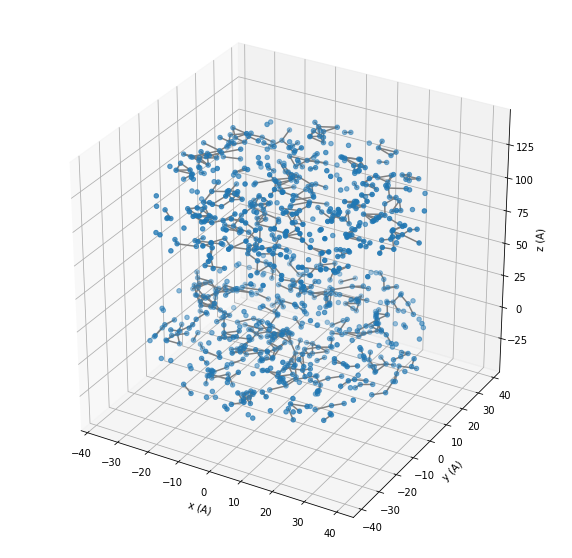

In [7]:
# add 3D axis
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# We want to visualize the smaller bath
data = calc.bath

# First plot the positions of the bath 
#colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
ax.scatter3D(data.x, data.y, data.z, cmap='viridis');
# Plot all pairs of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 2
for c in calc.clusters[2]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# Plot all triplets of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 3
#for c in calc.clusters[3]:
    #ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

When the number of central spins is greater than one, hyperfine couplings in the ``BathArray`` have an additional dimension, corresponding to the two sets of the hyperfine couplings.

In [8]:
print(calc.bath.A.shape)
print(calc.bath[0].A)

(961, 2, 3, 3)
[[[-0.0462 -0.0054 -0.0317]
  [-0.0054 -0.0487  0.0252]
  [-0.0317  0.0252  0.0949]]

 [[-0.2066 -0.1766  0.454 ]
  [-0.1766 -0.2893 -0.36  ]
  [ 0.454  -0.36    0.4959]]]


### Decoherence of entangled state
Let's do some calculations! Note that `gcce` method in this case includes a lot (9-fold) larger Hilbert space, so it will take a bit longer.

Here we compute the coherence function, defined as a decay of the offdiagonal element of the density matrix:

\begin{equation}
L=\langle 0 | \hat \rho | 1 \rangle
\end{equation}

Where $| 0 \rangle$ and $| 1 \rangle$ are defined as eigenstates of the central spin Hamiltonian introduced above.

In [9]:
ts = np.linspace(0, 2)
calc.alpha = 0 # 00 state
calc.beta = 1 # -10 state
cce = {}
gcce = {}

cce['01'] = calc.compute(ts, pulses=1)
gcce['01'] = calc.compute(ts, method='gcce', pulses=1)

calc.beta = 1 # 0-1 state
cce['02'] = calc.compute(ts, pulses=1)
gcce['02'] = calc.compute(ts, method='gcce', pulses=1)

calc.beta = 3 # -1 -1 state
%time cce['03'] = calc.compute(ts, pulses=1)
%time gcce['03'] = calc.compute(ts, method='gcce', pulses=1)


Wall time: 596 ms
Wall time: 44.7 s


As expected, in the case of decoupled NV centers the coherence of the bell state decays as a product of separated NVs decoherence.

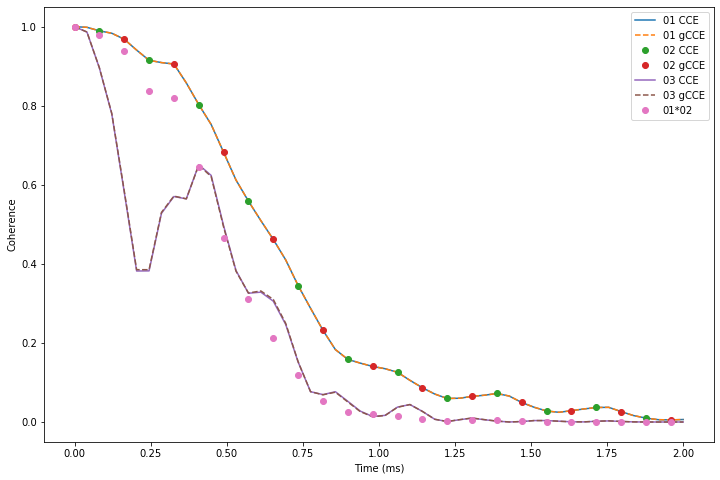

In [10]:
plt.plot(ts, cce['01'].real, label='01 CCE')
plt.plot(ts, gcce['01'].real, ls='--', label='01 gCCE')

plt.plot(ts, cce['02'].real, markevery=(2, 4), ls='', marker='o', label='02 CCE')
plt.plot(ts, gcce['02'].real, ls='', marker='o', markevery=4, label='02 gCCE')

plt.plot(ts, cce['03'].real, label='03 CCE')
plt.plot(ts, gcce['03'].real, ls='--', label='03 gCCE')

plt.plot(ts, gcce['02'].real * gcce['01'].real, ls='', marker='o', markevery=2, label='01*02')
plt.ylabel('Coherence')
plt.xlabel('Time (ms)')
plt.legend();

### Entanglement between two NVs

We can use the PyCCE to predict how the entanglement evolves between two dipolarly coupled electron spins, initially prepared in the product state:

\begin{equation}
| \Psi \rangle = \frac{1}{2} (| 0 \rangle + | -1 \rangle) \otimes (| 0 \rangle + | -1 \rangle)
\end{equation}

We add interaction between two NVs by calling `nvs.point_dipole` method, that generates interaction tensors from point dipole approximation. We can also directly set interaction tensors by calling `nvs.add_interaction` method or modifiying `nvs.imap` attribute.


In [11]:
nvs = pc.CenterArray(spin=[1, 1], D=[D, D],
                     position=[[0, 0, 0], [0, 0, 50]],
                     gyro=[gyro, gyro], alpha=0, beta=2)

nvs.point_dipole() # Add interactions

zero = np.array([0, 1, 0])
one  = np.array([0, 0, 1])
nvs[0].alpha = zero # Set qubit levels
nvs[0].beta = one
nvs[1].alpha = one
nvs[1].beta = zero

# Generate product state
state = pc.normalize(np.kron(zero + one, zero + one))
nvs.state = state
print("Initial amplitudes in Sz x Sz basis:", np.abs(nvs.state)) # Initial state
print("Interaction tensor:")
print(nvs.imap[0, 1]) # in kHz

Initial amplitudes in Sz x Sz basis: [0.  0.  0.  0.  0.5 0.5 0.  0.5 0.5]
Interaction tensor:
[[ 416.3281   -0.       -0.    ]
 [  -0.      416.3281   -0.    ]
 [  -0.       -0.     -832.6562]]


We will use negativity (https://en.wikipedia.org/wiki/Negativity_(quantum_mechanics)) as a metric of entanglement, defined as:

$ \mathcal{N}(\rho) \equiv \frac{||\rho^{\Gamma_A}||_1-1}{2}$

In [12]:
#          0      1     2     3      4     5     6       7       8
states = ['11', '10', '1-1', '01', '00', '0-1', '-11', '-10', '-1-1']

def pltdm(t, dm, ax):
    """
    Function to plot nonzero elements of the density matrix.
    """
    for i, j in np.argwhere(np.triu(dm[0])):
        label=r'$\langle$' + f'{states[i]}'+r'$|\rho|$'+ f'{states[j]}'+ r'$\rangle$'
        ax.plot(t, np.abs(dm[:, i, j]), label=label)


def partial_transpose(dm0, dim, which):
    """
    Get partial transpose of the density matrix.
    """
    ish = dm0.shape
    n = len(dim)
    indexes = np.arange(len(dim)*2)
    indexes[which] = n + which
    indexes[n + which] = which
    return dm0.reshape(*dim, *dim).transpose(*indexes).reshape(ish)

def negativities(dms):
    """
    Compute negativity for an array of density matrices.
    """
    negs = []
    for dm in dms:
        pt = partial_transpose(dm, [3,3], 0)
        tr_norm = np.linalg.norm(pt, ord='nuc')
        negs.append((tr_norm - 1) / 2)
    return np.array(negs)

def rz(dm):
    """
    Set density matrix elements equal to zero at zero timepoint to zero.
    Removes numerical instabilities when we divide by a near-zero value.
    """
    dm[np.broadcast_to((dm[0] == 0), dm.shape)] = 0
    return dm

First, compute the entanglement without dynamical decoupling pulses applied.

In [13]:
tfid = np.linspace(0, 0.01, 151)

c = pc.Simulator(nvs, bath=bath, r_bath=40, r_dipole=6,
                 order=2, pulses=0, magnetic_field=500)
dmfid = rz(c.compute(tfid, method='gcce', fulldm=True))

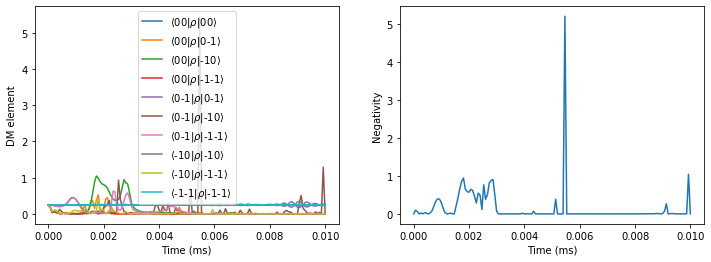

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pltdm(tfid, dmfid, axes[0])
axes[1].plot(tfid, negativities(dmfid))

axes[0].legend()
axes[0].set(ylabel='DM element', xlabel='Time (ms)')
axes[1].set(ylabel='Negativity', xlabel='Time (ms)');

Compare that to the case, when $\pi$ pulse is applied to each of the electron spins.

To create such pulse sequence, we specify the `which` keyword argument of the `Pulse` class with indexes of both NVs in the `CenterArray`.

In [15]:
# Pulse, flipping simultaneously the two NVs
p = pc.Pulse('x', np.pi, which=[0, 1])
the = np.linspace(0, 0.3, 151)

c = pc.Simulator(nvs, bath=bath, r_bath=40, r_dipole=6,
                 order=2, pulses=[p], magnetic_field=500)

dm_short = rz(c.compute(tfid, method='gcce', fulldm=True))
dm = rz(c.compute(the, method='gcce', fulldm=True))

As expected, we find a significantly prolonged entanglement between two electron spins.

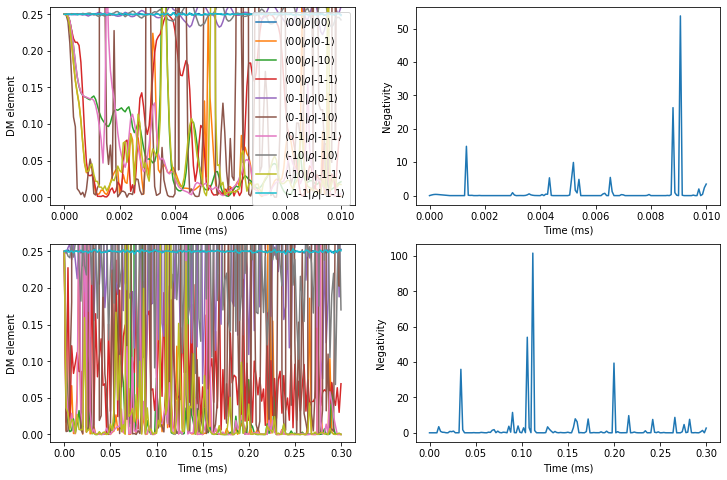

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

pltdm(tfid, dm_short, axes[0, 0])
axes[0, 1].plot(tfid, negativities(dm_short))

pltdm(the, dm, axes[1, 0])
axes[1, 1].plot(the, negativities(dm))

axes[0, 0].legend()

for row in axes:
    row[0].set(ylabel='DM element', xlabel='Time (ms)', ylim=(-0.01, 0.26))
    row[1].set(ylabel='Negativity', xlabel='Time (ms)')

## Si:Bi donor

We use the PyCCE framework to reproduce paper: PHYSICAL REVIEW B 91, 245416 (2015) by S. J. Balian et al. Here, $^{209}$Bi nuclear spin 9/2 and electron spin 1/2 interact very strongly (~1.5 GHz hyperfine), with many avoided crossings arising and leading to clock transitions. The qubit states is chosen as a two energy levels of the hybrid electron and nuclear spins system.



First, we prepare a `CenterArray`, containing the properties of two central spins.

In [17]:
aiso = 1.4754e6
im = np.eye(3) * aiso # Isotropic interaction tensor 
ebi = pc.CenterArray(spin=[1/2, 9/2],
                     gyro=[pc.ci['e'].gyro, pc.ci['209Bi'].gyro],
                     imap=im, alpha=6, beta=13)

For visualization purposes, plot a diagram of the energies of the hybrid system as a function of magnetic field.
Here the chosen qubit levels are highlighted with black points.

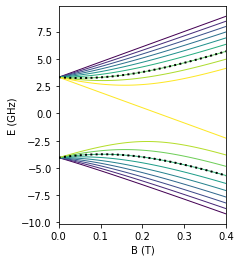

In [18]:
ens = []
ms = np.linspace(0, 4000, 51)  # applied magnetic field
for mf in ms:
    ebi.generate_states([0,0, mf])
    ens.append(ebi.energies)

ens = np.asarray(ens)

lowerdf = pd.DataFrame(ens[:, :10]/1e6, index=ms/1e4,
                       columns=np.arange(10))
higherdf = pd.DataFrame(ens[:, :10:-1]/1e6, index=ms/1e4,
                        columns=np.arange(11, ens.shape[1])[::-1])

fig, ax = plt.subplots(figsize=(3, 4))

lowerdf.plot(ax=ax, cmap='viridis', legend=False, lw=1)
higherdf.plot(ax=ax, cmap='viridis', legend=False, lw=1)
lowerdf[6].plot(ax=ax, color='black', ls=':', lw=2)
higherdf[13].plot(ax=ax, color='black', ls=':', lw=2)
ax.set(xlabel='B (T)', ylabel='E (GHz)', xlim=(0, 0.4));

Now we define the calculations of hyperfine couplings for the electron spin.

In [19]:
# PHYSICAL REVIEW B 68, 115322 (2003)
#  https://link.springer.com/content/pdf/10.1007%2FBF02725533.pdf for Bi
n_parameter = np.sqrt(0.029/0.069)
# https://journals.aps.org/pr/pdf/10.1103/PhysRev.114.1219
a_parameter = 25.09

def factor(x, y, z, n=n_parameter, a=a_parameter, b=14.43):
    top = np.exp(-np.sqrt(x ** 2 / (n * b) **2 + (y ** 2 + z ** 2) / (n * a) ** 2))
    bottom = np.sqrt(np.pi * (n * a) ** 2 * (n * b) )

    return top / bottom

def contact_si(r, gamma_n, gamma_e=pc.ELECTRON_GYRO, 
               a_lattice=5.43, nu=186, n=n_parameter,
               a=a_parameter, b=14.43):

    k0 = 0.85 * 2 * np.pi / a_lattice
    pre = 8 / 9 * gamma_n * gamma_e * pc.HBAR_MU0_O4PI * nu
    xpart = factor(r[0], r[1], r[2], n=n, a=a, b=b) * np.cos(k0 * r[0])
    ypart = factor(r[1], r[2], r[0], n=n, a=a, b=b) * np.cos(k0 * r[1])
    zpart = factor(r[2], r[0], r[1], n=n, a=a, b=b) * np.cos(k0 * r[2])
    return pre * (xpart + ypart + zpart) ** 2


def func(bath):
    na = np.newaxis
    aiso = contact_si(bath.xyz.T, bath.gyro) # Contact term
    # Generate dipolar terms
    bath.from_center(ebi) 
    # Add contact term for electron spni
    bath.A[:, 0] += np.eye(3)[na, :, :] * aiso[:, na, na]


And prepare the spin bath using `ase` interface.

In [20]:
si = pc.read_ase(bulk('Si', cubic=True))
atoms = si.gen_supercell(200, remove=('Si', [0., 0, 0]), seed=seed)

### Away from avoided crossings
Chosen energy levels 6 <-> 14 give raise to the clock transition (CT) at ~800 G. First compute the coherence avay from CT at 3200 G. It will take some time, as the bath is large.

In [21]:
nts = np.linspace(0, 2, 101)
sicalc = pc.Simulator(ebi, bath=atoms, r_bath=80, r_dipole=6,
                      order=2, magnetic_field=3200, pulses=1,
                      hyperfine=func)
orders = [1, 2, 3]

ls = []
for v in orders:
    sicalc.order = v
    ls.append(sicalc.compute(nts).real)

dfoff = pd.DataFrame(ls, columns=nts, index=orders).T

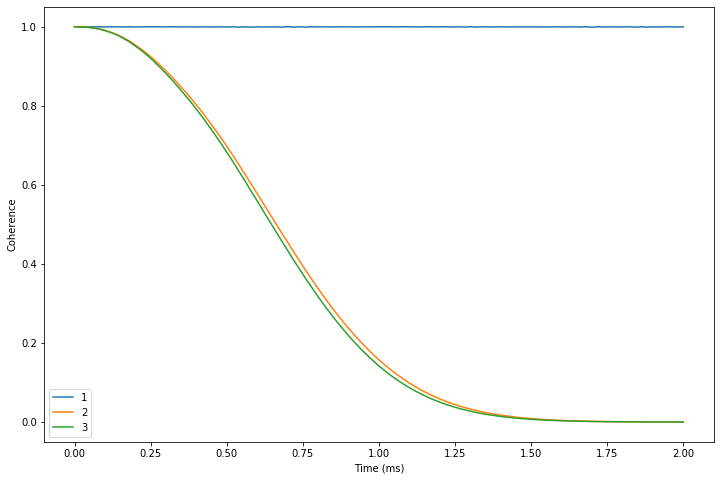

In [22]:
dfoff.plot()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence');

### Near avoided crossings

Now compare that to the coherence near the CT ( -4G from CT). Note, that number of clusters considered here is already rather large, so the calculations will take a minute or two.

In [23]:
ts = np.linspace(0, 100, 101)

sicalc.magnetic_field = 791
orders = [1, 2, 3, 4]

ls = []
for v in orders:
    sicalc.order = v
    ls.append(sicalc.compute(ts).real)

dfat = pd.DataFrame(ls, columns=ts, index=orders).T

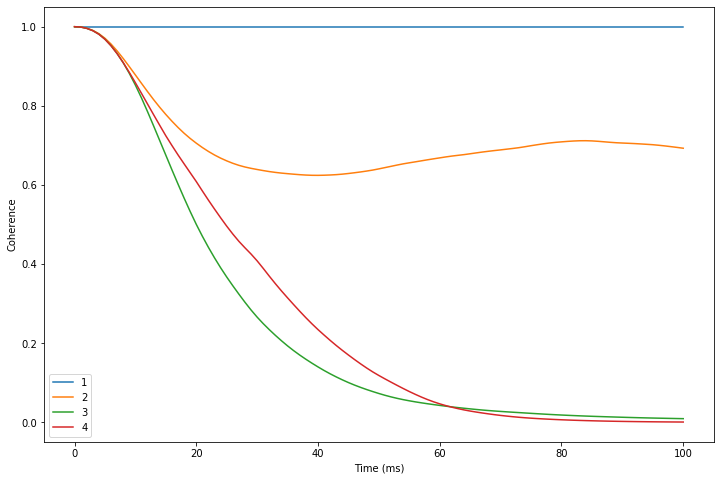

In [24]:
dfat.plot()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence');

Exactly at CT one needs even higher `order`, larger `r_bath` and `r_dipole`, and random bath state sampling to get accurate results. It is left as an exersize to the reader to try and converge the coherence at clock transition.